In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import random


In [ ]:
# Define dataset paths
dataset_paths = {
    'dangerous': '/content/drive/MyDrive/MiniProject/Screaming/dangerous_scream_augmented',
    'happy': '/content/drive/MyDrive/MiniProject/Screaming/happy_scream_wav_augmented',
    'non_screaming': '/content/drive/MyDrive/MiniProject/NotScreaming_Augmented'
}

# Function to extract MFCC features
def extract_features(file_path, max_pad_len=100):
    y, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfcc.shape[1]

    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]

    return mfcc

# Extract features and labels
X, y = [], []
label_map = {'dangerous': 2, 'happy': 1, 'non_screaming': 0}

for label, path in dataset_paths.items():
    for file in os.listdir(path):
        if file.endswith('.wav'):
            file_path = os.path.join(path, file)
            mfcc = extract_features(file_path)
            X.append(mfcc)
            y.append(label_map[label])

# Convert lists to numpy arrays
X = np.array(X).reshape(len(X), 40, 100, 1)  # Reshape for CNN
y = np.array(y)

# Save dataset
np.save("/content/drive/MyDrive/MiniProject/X.npy", X)
np.save("/content/drive/MyDrive/MiniProject/y.npy", y)

print("Feature extraction completed and saved as X.npy and y.npy!")


Feature extraction completed and saved as X.npy and y.npy!


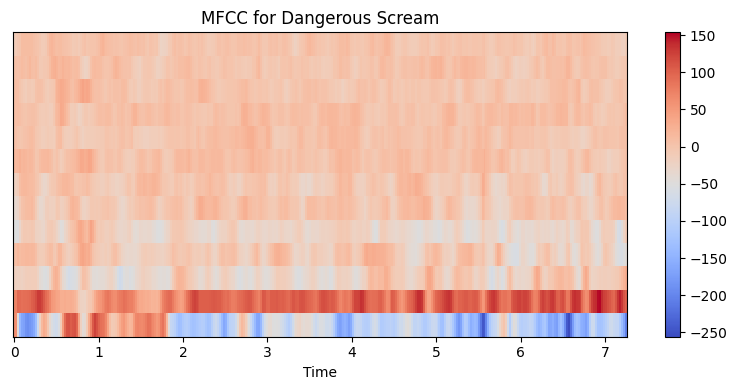

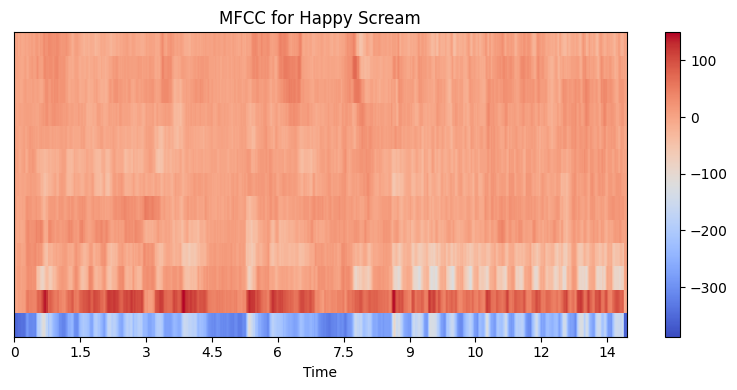

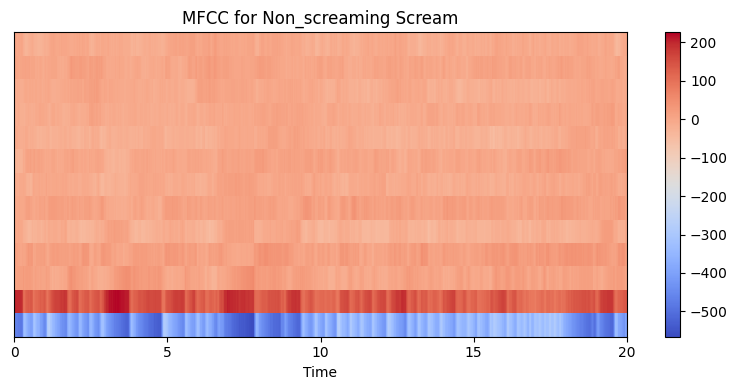

In [ ]:
# Folder paths for each category
sample_dirs = {
    "dangerous": '/content/drive/MyDrive/MiniProject/Screaming/dangerous_scream_augmented',
    "happy": '/content/drive/MyDrive/MiniProject/Screaming/happy_scream_wav_augmented',
    "non_screaming": '/content/drive/MyDrive/MiniProject/NotScreaming_Augmented'
}

# Function to plot MFCC
def plot_mfcc(audio_path, title):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mfcc, x_axis="time", cmap="coolwarm")
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Pick 1 random file from each category and plot its MFCC
for category, folder_path in sample_dirs.items():
    wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    if wav_files:
        random_file = random.choice(wav_files)
        full_path = os.path.join(folder_path, random_file)
        plot_mfcc(full_path, f"MFCC for {category.capitalize()} Scream")
    else:
        print(f"No .wav files found in {folder_path}")




In [ ]:
# Display dataset counts
dataset_counts = {category: len(os.listdir(path)) for category, path in sample_dirs.items()}

for category, count in dataset_counts.items():
    print(f"{category}: {count} audio files")

dangerous: 311 audio files
happy: 306 audio files
non_screaming: 300 audio files


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset from Google Drive
X = np.load('/content/drive/MyDrive/MiniProject/X.npy')
y = np.load('/content/drive/MyDrive/MiniProject/y.npy')

# One-hot encode the labels
y = to_categorical(y, num_classes=3)

# Split dataset into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model
cnn_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2], 1)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Setup checkpoint to save best model
checkpoint = ModelCheckpoint('/content/drive/MyDrive/MiniProject/best_cnn_model.h5',
                             monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
cnn_model.fit(X_train, y_train, epochs=20, batch_size=16,
              validation_data=(X_test, y_test), callbacks=[checkpoint])

# Evaluate on test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")




Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4593 - loss: 19.2831
Epoch 1: val_accuracy improved from -inf to 0.77174, saving model to /content/drive/MyDrive/MiniProject/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.4618 - loss: 19.0308 - val_accuracy: 0.7717 - val_loss: 0.6298
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7807 - loss: 0.5977
Epoch 2: val_accuracy improved from 0.77174 to 0.81522, saving model to /content/drive/MyDrive/MiniProject/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.7805 - loss: 0.5979 - val_accuracy: 0.8152 - val_loss: 0.5094
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8114 - loss: 0.4703
Epoch 3: val_accuracy improved from 0.81522 to 0.85870, saving model to /content/drive/MyDrive/MiniProject/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8120 - loss: 0.4694 - val_accuracy: 0.8587 - val_loss: 0.3780
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8555 - loss: 0.3848
Epoch 4: val_accuracy did not improve from 0.85870
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.8559 - loss: 0.3838 - val_accuracy: 0.8315 - val_loss: 0.4803
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8742 - loss: 0.3282
Epoch 5: val_accuracy improved from 0.85870 to 0.86413, saving model to /content/drive/MyDrive/MiniProject/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.8745 - loss: 0.3275 - val_accuracy: 0.8641 - val_loss: 0.3768
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9136 - loss: 0.2219
Epoch 6: val_accuracy improved from 0.86413 to 0.88587, saving model to /content/drive/MyDrive/MiniProject/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9137 - loss: 0.2218 - val_accuracy: 0.8859 - val_loss: 0.3114
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9269 - loss: 0.2106
Epoch 7: val_accuracy did not improve from 0.88587
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9268 - loss: 0.2109 - val_accuracy: 0.8587 - val_loss: 0.3939
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9350 - loss: 0.2018
Epoch 8: val_accuracy improved from 0.88587 to 0.90761, saving model to /content/drive/MyDrive/MiniProject/best_cnn_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9350 - loss: 0.2018 - val_accuracy: 0.9076 - val_loss: 0.2438
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9586 - loss: 0.1424
Epoch 9: val_accuracy did not improve from 0.90761
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9585 - loss: 0.1423 - val_accuracy: 0.9022 - val_loss: 0.2354
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9594 - loss: 0.1085
Epoch 10: val_accuracy did not improve from 0.90761
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.9592 - loss: 0.1092 - val_accuracy: 0.8641 - val_loss: 0.3835
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9595 - loss: 0.1012
Epoch 11: val_accuracy did not improve from 0.90761
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9595 - loss: 0.1011 - val_accuracy: 0.8967 - val_loss: 0.4113
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9566 - loss: 0.0976
Epoch 12: val_accuracy did not 

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9715 - loss: 0.0777 - val_accuracy: 0.9185 - val_loss: 0.2596
Epoch 16/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9761 - loss: 0.0831
Epoch 16: val_accuracy did not improve from 0.91848
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9760 - loss: 0.0833 - val_accuracy: 0.9185 - val_loss: 0.2635
Epoch 17/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9764 - loss: 0.0539
Epoch 17: val_accuracy did not improve from 0.91848
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.9764 - loss: 0.0543 - val_accuracy: 0.9022 - val_loss: 0.3686
Epoch 18/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9522 - loss: 0.1147
Epoch 18: val_accuracy did not improve from 0.91848
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9525 - loss: 0.1139 - val_accuracy: 0.8967 - val_loss: 0.3308
Epoch 19/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9727 - loss: 0.0583
Epoch 19: val_accuracy did no

In [ ]:
# Get the training and test accuracy
train_loss, train_acc = cnn_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

# Convert to percentage
train_acc_percentage = train_acc * 100
test_acc_percentage = test_acc * 100

# Print results
print(f"Training Accuracy: {train_acc_percentage:.2f}%")
print(f"Test Accuracy: {test_acc_percentage:.2f}%")


Training Accuracy: 99.59%
Test Accuracy: 88.04%


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


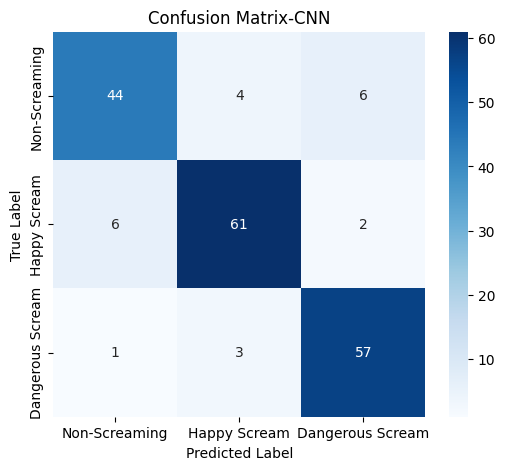

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Screaming', 'Happy Scream', 'Dangerous Scream'], yticklabels=['Non-Screaming', 'Happy Scream', 'Dangerous Scream'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix-CNN")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load dataset from Google Drive
X = np.load('/content/drive/MyDrive/MiniProject/X.npy')  # MFCC features
y = np.load('/content/drive/MyDrive/MiniProject/y.npy')  # Labels

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=3)

# Reshape X for LSTM input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define improved LSTM model
lstm_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),  # Correct shape for LSTM
    LSTM(128, return_sequences=True, activation='relu'),
    BatchNormalization(),  # Normalize activations
    LSTM(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
lstm_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# Evaluate model
train_loss, train_acc = lstm_model.evaluate(X_train, y_train)
test_loss, test_acc = lstm_model.evaluate(X_test, y_test)

# Print accuracies
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.3078 - loss: 1.4651 - val_accuracy: 0.3750 - val_loss: 3.0187
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.4157 - loss: 1.2178 - val_accuracy: 0.3478 - val_loss: 365.5544
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.3571 - loss: 1.1752 - val_accuracy: 0.3859 - val_loss: 1.0963
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.3910 - loss: 1.1650 - val_accuracy: 0.3913 - val_loss: 1.1106
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3749 - loss: 1.1126 - val_accuracy: 0.3967 - val_loss: 1.1095
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.4111 - loss: 1.1640 - val_accuracy: 0.3261 - val_loss: 1.1147
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.3837 - loss: 1.1240 - val_accuracy: 0.3315 - val_loss: 1.1570
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4585 - loss: 1.0448 - val_accuracy: 0.3207 -

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
# Evaluate and print only the accuracies
train_loss, train_acc = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Training Accuracy: 56.07%
Test Accuracy: 52.17%


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


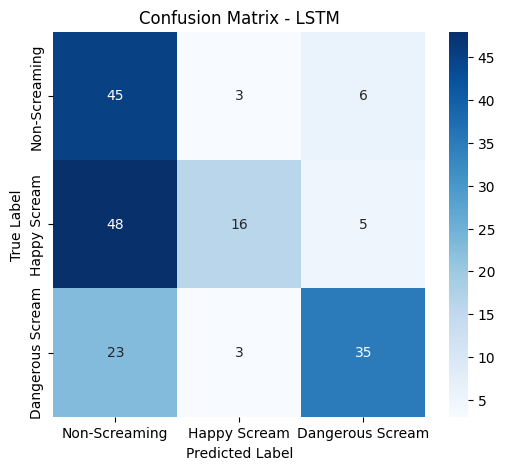

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on test set
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Screaming', 'Happy Scream', 'Dangerous Scream'], yticklabels=['Non-Screaming', 'Happy Scream', 'Dangerous Scream'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical

# Check shape (for Colab output)
print("Original X_train Shape:", X_train.shape)

# Reshape if shape is 4D (samples, time_steps, features, 1) → make it 3D for Conv1D/LSTM
if len(X_train.shape) == 4:
    X_train = np.squeeze(X_train, axis=-1)
    X_test = np.squeeze(X_test, axis=-1)

print("Reshaped X_train Shape:", X_train.shape)  # Expected: (samples, time_steps, features)

# Build CNN-LSTM Model
cnn_lstm_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    Dropout(0.4),
    LSTM(128),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Adjust based on number of classes
])

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
train_loss, train_acc = cnn_lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)

# Print accuracies
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


Original X_train Shape: (733, 40, 100)
Reshaped X_train Shape: (733, 40, 100)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.3726 - loss: 1.0873 - val_accuracy: 0.6413 - val_loss: 0.7952
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6427 - loss: 0.7949 - val_accuracy: 0.6685 - val_loss: 0.7426
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6764 - loss: 0.7337 - val_accuracy: 0.7011 - val_loss: 0.7438
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7662 - loss: 0.6160 - val_accuracy: 0.7174 - val_loss: 0.6514
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7736 - loss: 0.6056 - val_accuracy: 0.7772 - val_loss: 0.6285
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7933 - loss: 0.5159 - val_accuracy: 0.7337 - val_loss: 0.6448
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8192 - loss: 0.4942 - val_accuracy: 0.6957 - val_loss: 0.7583
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8048 - loss: 0.4894 - val_accuracy: 0.7554 - val_loss: 0.

In [ ]:
# Get the training and test accuracy
train_loss, train_acc = cnn_lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)

# Convert to percentage
train_acc_percentage = train_acc * 100
test_acc_percentage = test_acc * 100

# Print results
print(f"Training Accuracy: {train_acc_percentage:.2f}%")
print(f"Test Accuracy: {test_acc_percentage:.2f}%")


Training Accuracy: 92.22%
Test Accuracy: 80.43%


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


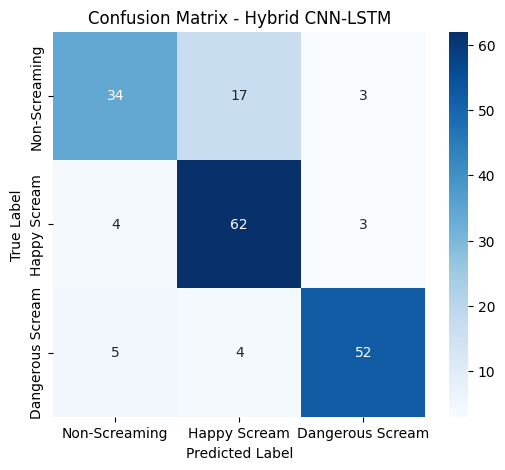

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on test set
y_pred = cnn_lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Screaming', 'Happy Scream', 'Dangerous Scream'],
            yticklabels=['Non-Screaming', 'Happy Scream', 'Dangerous Scream'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Hybrid CNN-LSTM")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Convert probabilities to class labels for y_pred
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Use y_true directly (since it's already in label format)
y_true_classes = y_true  # No need for argmax if it's already 1D

# Generate classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Non-Screaming', 'Happy Scream', 'Dangerous Scream']))


Classification Report:
                  precision    recall  f1-score   support

   Non-Screaming       0.79      0.63      0.70        54
    Happy Scream       0.75      0.90      0.82        69
Dangerous Scream       0.90      0.85      0.87        61

        accuracy                           0.80       184
       macro avg       0.81      0.79      0.80       184
    weighted avg       0.81      0.80      0.80       184



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset (Make sure X.npy and y.npy are uploaded/mounted in Colab)
X = np.load('/content/drive/MyDrive/MiniProject/X.npy')  # MFCC features
y = np.load('/content/drive/MyDrive/MiniProject/y.npy')  # Labels

# Print initial shape for verification
print("Original X shape:", X.shape)

# Reshape X for SVM (flatten MFCC features)
X = X.reshape(X.shape[0], -1)  # (samples, features)
print("Reshaped X shape for SVM:", X.shape)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for SVM performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nData preparation complete for SVM")



Original X shape: (917, 40, 100, 1)
Reshaped X shape for SVM: (917, 4000)

Data preparation complete for SVM


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Evaluate Model
train_acc = accuracy_score(y_train, svm_model.predict(X_train)) * 100
test_acc = accuracy_score(y_test, svm_model.predict(X_test)) * 100

# Print accuracy
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")


Training Accuracy: 97.14%
Test Accuracy: 83.15%


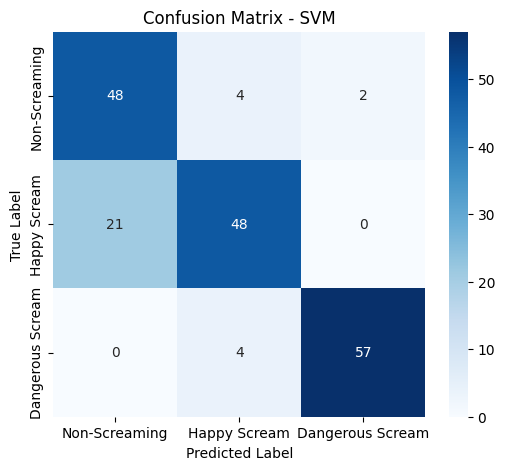

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on test set
y_pred = svm_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Screaming', 'Happy Scream', 'Dangerous Scream'], yticklabels=['Non-Screaming', 'Happy Scream', 'Dangerous Scream'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()


KNN Training Accuracy: 79.26%
KNN Test Accuracy: 77.17%

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67        54
           1       0.67      0.80      0.73        69
           2       1.00      0.85      0.92        61

    accuracy                           0.77       184
   macro avg       0.79      0.77      0.77       184
weighted avg       0.79      0.77      0.78       184



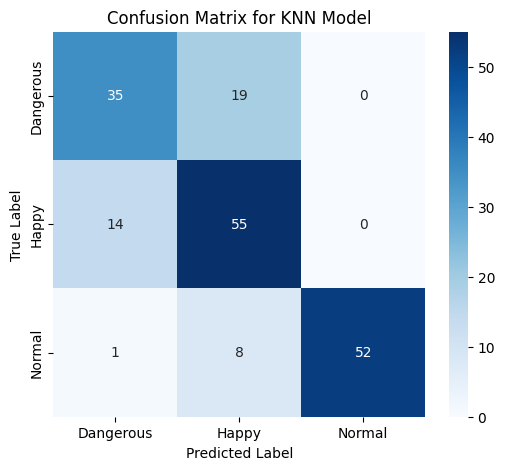

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Check if y_train is one-hot encoded; convert it to labels if needed
if len(y_train.shape) > 1:
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_train_labels = y_train
    y_test_labels = y_test

# Feature Scaling (KNN works better with normalized data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN Model (Using k=5 and Euclidean distance)
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_scaled, y_train_labels)

# Predictions
y_pred = knn.predict(X_test_scaled)

# Model Evaluation
train_acc = knn.score(X_train_scaled, y_train_labels) * 100
test_acc = accuracy_score(y_test_labels, y_pred) * 100
conf_matrix = confusion_matrix(y_test_labels, y_pred)
class_report = classification_report(y_test_labels, y_pred)

# Display Results
print(f"KNN Training Accuracy: {train_acc:.2f}%")
print(f"KNN Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:")
print(class_report)

# 🎨 Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Dangerous', 'Happy', 'Normal'], yticklabels=['Dangerous', 'Happy', 'Normal'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN Model")
plt.show()


In [ ]:
# Save the trained CNN model
cnn_model.save("scream_detection_cnn.keras")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
print(cnn_model.summary())  # will throw error if not defined


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 100, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,048,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,201,995 (23.66 MB)

 Trainable params: 2,067,331 (7.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,134,664 (15.77 MB)

None


In [ ]:
from tensorflow.keras.models import load_model

# Load model without optimizer
cnn_model = load_model("scream_detection_cnn.keras", compile=False)

# Compile the model again with a new optimizer
cnn_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

print("Model loaded and recompiled successfully!")


Model loaded and recompiled successfully!


In [ ]:
import numpy as np
import librosa
import librosa.display
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained CNN model
cnn_model = load_model("scream_detection_cnn.keras", compile=False)

# Function to extract MFCC features in 2D shape
def extract_features(file_path, sr=22050, n_mfcc=40, max_len=100):
    y, sr = librosa.load(file_path, sr=sr)  # Load audio file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC features

    # Pad or truncate MFCC to match required input shape (40, max_len)
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return np.expand_dims(mfcc, axis=-1)  # Add channel dimension for CNN

# Function to classify an uploaded audio file
def predict_audio(file_path, model):
    feature = extract_features(file_path)  # Extract features
    feature = np.expand_dims(feature, axis=0)  # Reshape for model input (1, 40, 100, 1)

    prediction = model.predict(feature)  # Get prediction
    predicted_label = np.argmax(prediction)  # Get class with highest probability

    # Label Mapping (Modify based on your classes)
    labels = {0: "Normal Conversation", 1: "Happy Scream", 2: "Dangerous Scream"}

    return labels[predicted_label]

# Example: Test with an audio file
audio_file_to_test = "audio.wav"
predicted_label = predict_audio(audio_file_to_test, cnn_model)

print(f"The predicted label for {audio_file_to_test} is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
The predicted label for audio.wav is: Normal Conversation


In [ ]:
import numpy as np
import librosa
import librosa.display
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained CNN model
cnn_model = load_model("scream_detection_cnn.keras", compile=False)

# Function to extract MFCC features in 2D shape
def extract_features(file_path, sr=22050, n_mfcc=40, max_len=100):
    y, sr = librosa.load(file_path, sr=sr)  # Load audio file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC features

    # Pad or truncate MFCC to match required input shape (40, max_len)
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return np.expand_dims(mfcc, axis=-1)  # Add channel dimension for CNN

# Function to classify an uploaded audio file
def predict_audio(file_path, model):
    feature = extract_features(file_path)  # Extract features
    feature = np.expand_dims(feature, axis=0)  # Reshape for model input (1, 40, 100, 1)

    prediction = model.predict(feature)  # Get prediction
    predicted_label = np.argmax(prediction)  # Get class with highest probability

    # Label Mapping (Modify based on your classes)
    labels = {0: "Normal Conversation", 1: "Happy Scream", 2: "Dangerous Scream"}

    return labels[predicted_label]

# Example: Test with an audio file
audio_file_to_test = "audio5.wav"
predicted_label = predict_audio(audio_file_to_test, cnn_model)

print(f"The predicted label for {audio_file_to_test} is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
The predicted label for audio5.wav is: Dangerous Scream


In [ ]:
import numpy as np
import librosa
import librosa.display
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained CNN model
cnn_model = load_model("scream_detection_cnn.keras", compile=False)

# Function to extract MFCC features in 2D shape
def extract_features(file_path, sr=22050, n_mfcc=40, max_len=100):
    y, sr = librosa.load(file_path, sr=sr)  # Load audio file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC features

    # Pad or truncate MFCC to match required input shape (40, max_len)
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return np.expand_dims(mfcc, axis=-1)  # Add channel dimension for CNN

# Function to classify an uploaded audio file
def predict_audio(file_path, model):
    feature = extract_features(file_path)  # Extract features
    feature = np.expand_dims(feature, axis=0)  # Reshape for model input (1, 40, 100, 1)

    prediction = model.predict(feature)  # Get prediction
    predicted_label = np.argmax(prediction)  # Get class with highest probability

    # Label Mapping (Modify based on your classes)
    labels = {0: "Normal Conversation", 1: "Happy Scream", 2: "Dangerous Scream"}

    return labels[predicted_label]

# Example: Test with an audio file
audio_file_to_test = "youtube_v6vkN_2u104_audio_pitched.wav"
predicted_label = predict_audio(audio_file_to_test, cnn_model)

print(f"The predicted label for {audio_file_to_test} is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
The predicted label for youtube_v6vkN_2u104_audio_pitched.wav is: Happy Scream


In [ ]:
import pickle

# Replace 'model' with your trained model's variable name
with open("model.pkl", "wb") as f:
    pickle.dump(cnn_model, f)

NameError: name 'cnn_model' is not defined